In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sys import version
import model

print(f"Python: {version}")
print(f"  >      numpy: {np.__version__}")
print(f"  > matplotlib: {mpl.__version__}")

Python: 3.12.8 (main, Dec  3 2024, 18:42:41) [GCC 14.2.1 20241116]
  >      numpy: 2.2.2
  > matplotlib: 3.10.0


In [2]:
N_gpe, N_stn = 4, 0
dt = 0.01
def I_app(t, n):
    return [
        20.,
        0.,
        -0.5,
        170. if 150 < t * dt < 200 else 0.,
    ][int(n)]

data = model.rubin_terman(N_gpe, N_stn, I_app_gpe=I_app, dt=dt, T=1)
print(list(data.keys()))

['I_L_stn', 'I_K_stn', 'I_Na_stn', 'I_T_stn', 'I_Ca_stn', 'I_AHP_stn', 'I_ext_stn', 'Ca_stn', 'v_stn', 'I_L_gpe', 'I_K_gpe', 'I_Na_gpe', 'I_T_gpe', 'I_Ca_gpe', 'I_AHP_gpe', 'I_ext_gpe', 'I_app_gpe', 'Ca_gpe', 'v_gpe']


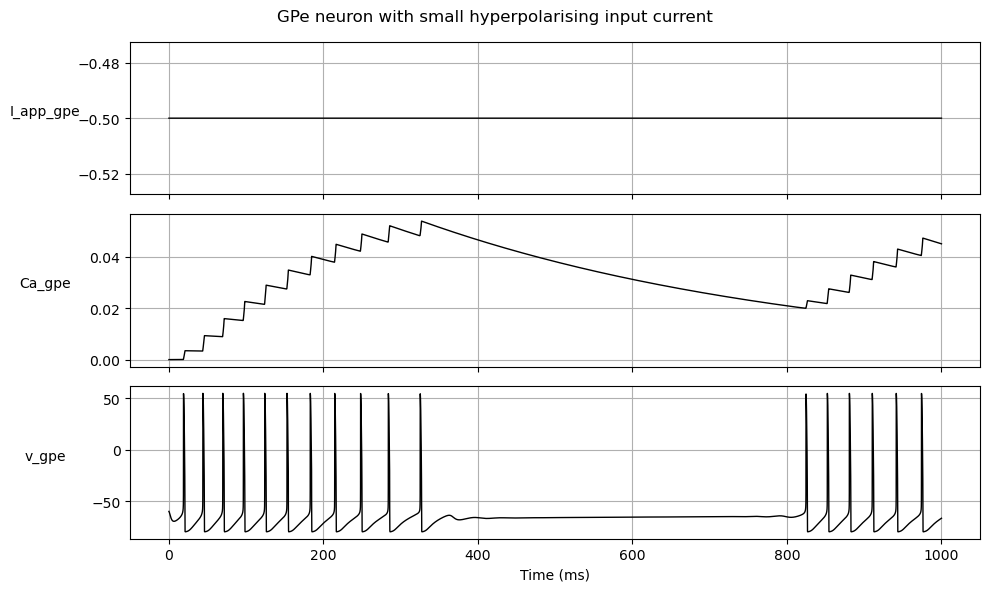

In [3]:
metrics = ["I_app_gpe", "Ca_gpe", "v_gpe"] 
fig, axs = plt.subplots(len(metrics), 1, figsize=(10, len(metrics)*2), sharex=True, tight_layout=True)

for k, ax in zip(metrics, axs):
    ax.plot(data[k][:,2], 'k', lw=1)
    ax.set_ylabel(f"{k}", rotation=0, labelpad=10)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.grid()

axs[-1].xaxis.set_major_formatter(lambda x, _: f"{x*0.01:.0f}")
axs[-1].set_xlabel("Time (ms)")

fig.suptitle("GPe neuron with small hyperpolarising input current")

plt.savefig("gpe_Iapp_170.svg")
plt.show()

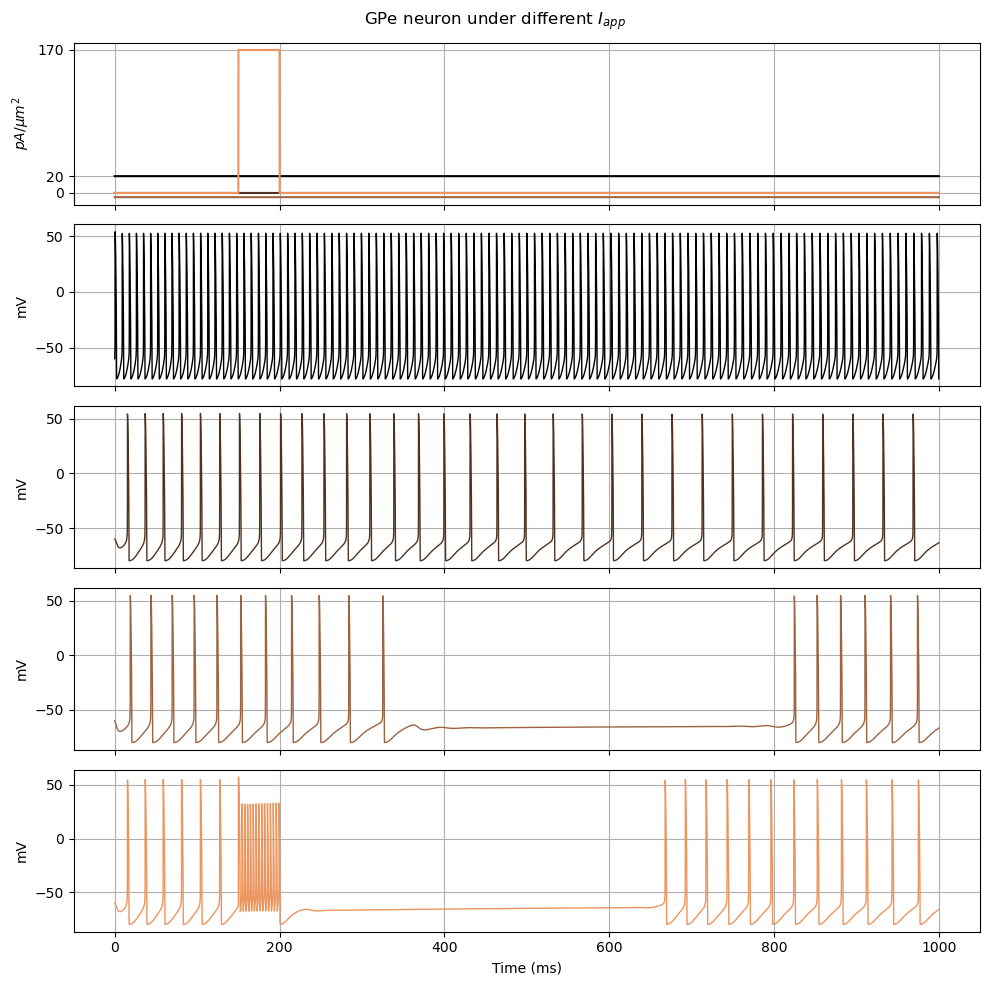

In [4]:
plots = data["v_gpe"].shape[1] + 1
fig, (a0, *axs) = plt.subplots(plots, 1, figsize=(10, plots*2), sharex=True, tight_layout=True)
colors = plt.get_cmap("copper", data["v_gpe"].shape[1]+1)

scale = [1, 1, 10, 1]
for i in range(data["I_app_gpe"].shape[1]):
    a0.plot(data["I_app_gpe"][:,i] * scale[i], color=colors(i))

a0.set_ylabel(r"$pA/\mu m^2$")
a0.set_yticks([0, 20, 170])
a0.grid()

for i, ax in zip(range(data["I_app_gpe"].shape[1]), axs):
    ax.plot(data["v_gpe"][:,i], color=colors(i), lw=1)
    ax.set_ylabel("mV")
    ax.grid()

axs[-1].xaxis.set_major_formatter(lambda x, _: f"{x*0.01:.0f}")
axs[-1].set_xlabel("Time (ms)")

fig.suptitle(r"GPe neuron under different $I_{app}$")
fig.savefig("gpe_Iapp_sweep.svg")
plt.show()

In [5]:
# plots = data["v_stn"].shape[1] + 1
# fig, (a0, *axs) = plt.subplots(plots, 1, figsize=(10, plots*2), sharex=True, tight_layout=True)

# for i in range(data["I_ext"].shape[1]):
#     a0.plot(-data["I_ext"][:,i], 'k', alpha=[0.6, 0.8, 1][i])
#     a0.set_ylabel(r"$pA/\mu m^2$")
#     a0.set_yticks([0, -25])
#     a0.grid()
    
# for i, ax in zip(range(data["I_ext"].shape[1]), axs):
#     ax.plot(data["v_stn"][:,i], 'k', alpha=[0.6, 0.8, 1][i], lw=1)
#     ax.set_ylabel("mV")
#     # ax.yaxis.set_label_coords(-0.1, 0.5)
#     ax.grid()

# axs[-1].xaxis.set_major_formatter(lambda x, _: f"{x*0.01:.0f}")
# axs[-1].set_xlabel("Time (ms)")

# fig.suptitle("STN neuron, hyperpolarising rebound bursts")
# # fig.savefig("stn_rebound_1.svg")
# plt.show()